# TP2- Modelo con estructura XGBoost

## Set up inicial

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

## Carga de los datasets y info

Se cargan las columnas con formatos adecuados según el tipo de datos. Se usa como índice building_id

In [2]:
# Train values
# Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
train_values = pd.read_csv('datos/train_values.csv',dtype=datatypes)
train_values = train_values.set_index("building_id")
columnas = train_values.columns.to_list()

In [3]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int16   
 1   geo_level_2_id                          260601 non-null  int16   
 2   geo_level_3_id                          260601 non-null  int16   
 3   count_floors_pre_eq                     260601 non-null  int16   
 4   age                                     260601 non-null  int16   
 5   area_percentage                         260601 non-null  int16   
 6   height_percentage                       260601 non-null  int16   
 7   land_surface_condition                  260601 non-null  category
 8   foundation_type                         260601 non-null  category
 9   roof_type                               260601 non-null  category
 10  ground_floor_type          

In [4]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [5]:
#Train labels
train_labels = pd.read_csv('datos/train_labels.csv',index_col='building_id')

In [6]:
train_labels.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [7]:
# Se seleccionan las columnas que vamos a usar para entrenar el modelo.
# Podemos usar todas, algunas, crear nuevas, etc.
# Para correr esta vez vamos a usar pocas para que corra rápido
# Notar que foundation_type es categórica. Tampoco, como en RF, se puede usar variables categóricas
selected_features = train_values.columns.to_list()
train_values_subset = train_values[selected_features]

In [8]:
train_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,o,r,n,...,False,False,False,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,t,r,n,...,False,False,False,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,t,r,n,...,False,False,False,False,False,False,False,False,False,False


In [9]:
train_values_subset['foundation_type'].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

## Preprocesamiento de los datos

In [16]:
## Convierte las variables categóricas en columnas booleanas a 0 o 1. Se le llama One-Hot-Encoding(En los videos de Feature Engineering para más info)
## Por ej foundation_type tiene 5 tipos: r, w, u. i,h Se crean 5 columnas para cada registro y según sea su foundation_type va a tener 1 en la respectiva columna y 0 en las otras 2.
train_values_subset = pd.get_dummies(train_values)

In [17]:
## Por ejemplo el primer edificio de building_id 802906 era de foundation_type 'r', entonces en la columna foundation_type_r tendrá un 1 (y solo en esa).
train_values_subset.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,True,True,False,...,0,0,0,0,0,0,0,0,1,0
28830,8,900,2812,2,10,8,7,False,True,False,...,0,0,0,0,0,0,0,0,1,0
94947,21,363,8973,2,10,5,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
590882,22,418,10694,2,10,6,5,False,True,False,...,0,0,0,0,0,0,0,0,1,0
201944,11,131,1488,3,30,8,9,True,False,False,...,0,0,0,0,0,0,0,0,1,0


## Creacion de Modelo de ML (XGBoost)

In [18]:
import xgboost as xgb

In [19]:
## Objective: mult:softprob. Es una softmax (clasificación de mas de 2 clases, como en este caso que hay 3 daños)
## Learning_rate: un valor alto puede saltearse en óptimo y uno muy bajo puede quedarse atrapado en un mínimo local
## XGBoost usa todos los nucleos (njobs=-1) por defecto
xgb_model = xgb.XGBClassifier(objective="multi:softmax",eval_metric='mlogloss',random_state=99)
xgb_model.fit(train_values_subset,train_labels.values.ravel() )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=99,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
from sklearn.metrics import f1_score
y_pred = xgb_model.predict(train_values_subset)
f1_score(train_labels, y_pred, average='micro')

0.7452197036849436

In [32]:
## Podemos guardar el modelo en un archivo para no tener que hacer xgb_model.fit() de vuelta.
## Si queremos cambiar los features, hiperparámetros, etc. No queda otra que hacerlo de nuevoimport pickle
import pickle
filename = 'modelos/xgb_modelo_inicial.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

Se puede cargar el modelo así

In [33]:
xgb_model = pickle.load(open(filename, 'rb'))

Ejemplo de que funciona como antes

In [34]:
y_pred = xgb_model.predict(train_values_subset)
f1_score(train_labels, y_pred, average='micro')

0.7452197036849436

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

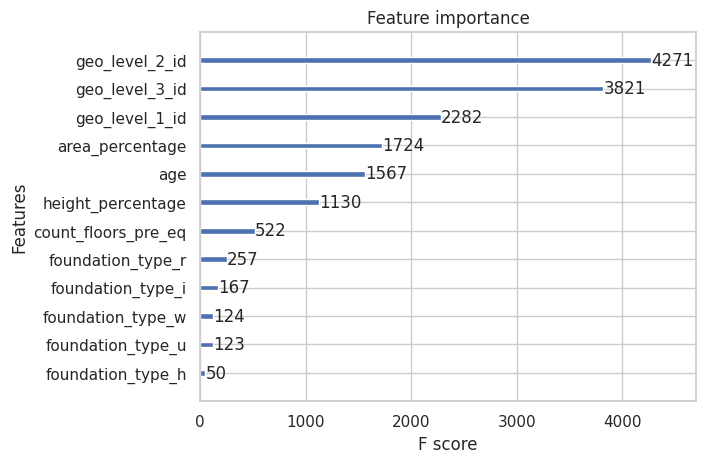

In [20]:
xgb.plot_importance(xgb_model)

## Predecir el set de test de DrivenData

Tenemos que predecir nuevos valores de los que desconocemos sus labels o daños.  
Solo tenemos sus columnas o features. Vamos a utilizar nuestro modelo para predecir.

In [22]:
test_values = pd.read_csv('datos/test_values.csv', index_col='building_id')

In [23]:
test_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


El set de test tiene que tener el MISMO formato que usamos para entrenar.  
Es decir, si le hicimos algunas modificaciones en las columnas al set de entrenamiento, también tenemos que hacerlas al set de test.  
En este caso, solo seleccionamos algunas columnas y utilizamos One-Hot-Encoding para las variables categóricas (sget_dummies)

In [24]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

Predecimos con gs.predict. Le pasamos los valores del set de test.

In [25]:
predictions = xgb_model.predict(test_values_subset)

Guardamos el submit. Lo pasamos a Pandas y de ahí a CSV (por tema de formato).  
Esto es lo que se sube a la página de DrivenData

In [26]:
submission_format = pd.read_csv('datos/submission_format.csv', index_col='building_id')

In [27]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [28]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [29]:
## Cambiar el nombre para que no se pise con otros submissions.
my_submission.to_csv('submissions/last_submission.csv')

Una mirada adentro del csv

In [31]:
!head 'submissions/last_submission.csv'

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
